In [4]:
# Make sure we can import EMQST_lib from parent directory
import sys
from pathlib import Path

# Go two levels up from current working directory
PROJECT_ROOT = Path.cwd().resolve().parents[1]   # <- one up (your earlier case)


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Using project root:", PROJECT_ROOT)

# Notebook is in project-root/Multiplexed_qubit_readout_results/
# -> project root is the parent of the current working dir
PROJECT_ROOT = Path.cwd().resolve().parent


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import numpy as np 
from datetime import datetime
import os
import uuid
import glob
from EMQST_lib import adaptive_functions as ad
from EMQST_lib.qst import QST  
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import support_functions as sf
from EMQST_lib.povm import POVM
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from EMQST_lib.visualization import power_law
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.autolayout"] = True
cmap        = colormaps['Dark2']
box_props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
%load_ext autoreload
%autoreload 2

one_qubit_adaptive_inf_con = []
one_qubit_nonadaptive_inf_con = []

load_path = 'adaptive_results/one_qubit_100k' #two_qubit_longtest'
glob_path = os.path.join(load_path, '*.npy')
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(load_path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        one_qubit_setting_array = np.load(f, allow_pickle=True)
    one_qubit_adaptive_inf_con.append(infidelity_dict['adaptive_infidelity_container'])
    one_qubit_nonadaptive_inf_con.append(infidelity_dict['nonadaptive_infidelity_container'])
one_qubit_noise_strengths = one_qubit_setting_array[0]['noise_strengths']



Using project root: /workspaces/REMQST
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 41 folders
Folder 0: adaptive_results/one_qubit_100k/2025-10-17_23-32-05_31a2ced7-9c12-40d8-bb62-a28cc6d7138c
Folder 1: adaptive_results/one_qubit_100k/2025-10-17_23-32-05_58b08872-81b5-4358-af40-d8460c018392
Folder 2: adaptive_results/one_qubit_100k/2025-10-17_23-32-05_78d72a60-21f4-4d30-bc38-033ac8c314ea
Folder 3: adaptive_results/one_qubit_100k/2025-10-19_17-28-22_9ac673a0-a247-4f7a-8b8f-f9901e0a66cf
Folder 4: adaptive_results/one_qubit_100k/2025-10-19_18-02-53_8174d289-5c9e-43ec-b512-7ab1a7de798f
Folder 5: adaptive_results/one_qubit_100k/2025-10-19_18-37-55_834a5b7b-7fc6-409f-b299-a912fe8e8a66
Folder 6: adaptive_results/one_qubit_100k/2025-10-19_19-13-58_eb6f04a5-d426-4c72-8d73-78ad6f171ca3
Folder 7: adaptive_results/one_qubit_100k/2025-10-19_19-15-44_d6cc716b-1a10-498e-99e9-c81bbb023ae5
Folder 8: adaptive_results/one_qubit_100k/2025-10-19_19-15-44_e1

## Old plots style

In [2]:
n_shots_total = 10**3
n_qubits = 2
n_shots = n_shots_total//3**n_qubits # In the qst code it is assumed that each single qubit measurement is a Pauli-basis, hence 3^n_qubits total measurement settings.
n_averages = 1
adaptive_burnin = 200
n_cores = 6
print(f'Starting adaptive QST with {n_shots_total} shots, {n_qubits} qubits, {n_averages} averages, and adaptive burnin of {adaptive_burnin}.')

true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])
povm = POVM.generate_Pauli_POVM(n_qubits)
decompiled_array = np.array([povm[i].get_POVM() for i in range(len(povm))])
pauli_6_array = 1/3**(n_qubits)*np.array(decompiled_array.reshape(-1,decompiled_array.shape[-2],decompiled_array.shape[-1]))
test_POVM = POVM(pauli_6_array)
qst_adaptive = QST(povm, true_states, n_shots, n_qubits, False,{}, n_cores=n_cores)


print(f'Total shots for the whole run: {n_shots_total * n_averages}')

n_steps = 2
noise_step = 0.1
infidelity_container_nonadaptive = []
infidelity_container_adaptive = []
qst_array = []
noise_strengths = []
setting_array = []

start_time = datetime.now()


for i in range(n_steps):
    # Adaptive QST
    print(f'Starting adaptive QST run {i}')
    depolarizing_strength = i * noise_step
    qst_adaptive = QST(povm, true_states, n_shots, n_qubits, False,{}, n_cores=n_cores)
    qst_adaptive.perform_adaptive_BME(depolarizing_strength = depolarizing_strength,
                            adaptive_burnin_steps = adaptive_burnin)

    noise_strengths.append(depolarizing_strength)
    qst_array.append(qst_adaptive)
    infidelity_container_adaptive.append(qst_adaptive.get_infidelity())
    print(f'Adaptive QST run {i} took {datetime.now()-start_time}')
    # For non_adaptive QST we need to supply it with the noisy POVM separatly. 
    depolarized_pauli_6_array = np.array([sf.depolarizing_channel(np.copy(element), depolarizing_strength) for element in pauli_6_array])
    noisy_povm = POVM(depolarized_pauli_6_array)
    # # Note that we use n_shots*3**n_qubits here, since nonadaptive QST does not split the shots between different measurement settings. 
    # # We also multiply rather than use n_shots total since there could be rounding difference between the adaptive and non-daptive QST. 
    qst_nonadaptive = QST([noisy_povm], true_states, n_shots*3**n_qubits, n_qubits, False,{}, n_cores=n_cores) # They are initalized the same
    qst_nonadaptive.generate_data()
    qst_nonadaptive.perform_BME()
    infidelity_container_nonadaptive.append(qst_nonadaptive.get_infidelity())
    
    
    settings = {
        'n_shots': n_shots,
        'n_qubits': n_qubits,
        'n_averages': n_averages,
        'adaptive_burnin': adaptive_burnin,
        'noise_strengths': noise_strengths,
        'true_states': true_states,
        'reconstructed_states_adaptive': qst_adaptive.get_rho_estm(),
        'reconstructed_states_nonadaptive': qst_nonadaptive.get_rho_estm(),
    }
    setting_array.append(settings)



container_dict = {
    'adaptive_infidelity_container': infidelity_container_adaptive,
    'nonadaptive_infidelity_container': infidelity_container_nonadaptive
}


Starting adaptive QST with 1000 shots, 2 qubits, 1 averages, and adaptive burnin of 200.
Total shots for the whole run: 1000
Starting adaptive QST run 0


KeyboardInterrupt: 

In [33]:
adaptive_infidelity_container = []
nonadaptive_infidelity_container = []

load_path = 'adaptive_results/two_qubit_test'
glob_path = os.path.join(load_path, '*.npy')
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(load_path, "*")) if os.path.isdir(f)]
print(f'Found folders: {folders}')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        setting_array = np.load(f, allow_pickle=True)
    adaptive_infidelity_container.append(infidelity_dict['adaptive_infidelity_container'])
    nonadaptive_infidelity_container.append(infidelity_dict['nonadaptive_infidelity_container'])
    
print(len(adaptive_infidelity_container))
    
print(setting_array[0].keys())

Found folders: ['adaptive_results/two_qubit_test/2025-10-14_13-05-24_54adb972-835f-4e59-a3ae-be228b9942a2', 'adaptive_results/two_qubit_test/2025-10-14_13-50-15_b8ee0cf3-86d4-4a47-a971-b37645adc32e']
Folder 0: adaptive_results/two_qubit_test/2025-10-14_13-05-24_54adb972-835f-4e59-a3ae-be228b9942a2
Folder 1: adaptive_results/two_qubit_test/2025-10-14_13-50-15_b8ee0cf3-86d4-4a47-a971-b37645adc32e
2
dict_keys(['n_shots', 'n_qubits', 'n_averages', 'adaptive_burnin', 'noise_strengths', 'true_states', 'reconstructed_states_adaptive', 'reconstructed_states_nonadaptive'])


(2, 5, 1998)
(2, 5, 1998)
(2, 2, 1998)
[[0.0, 0.1], [0.0, 0.1]]


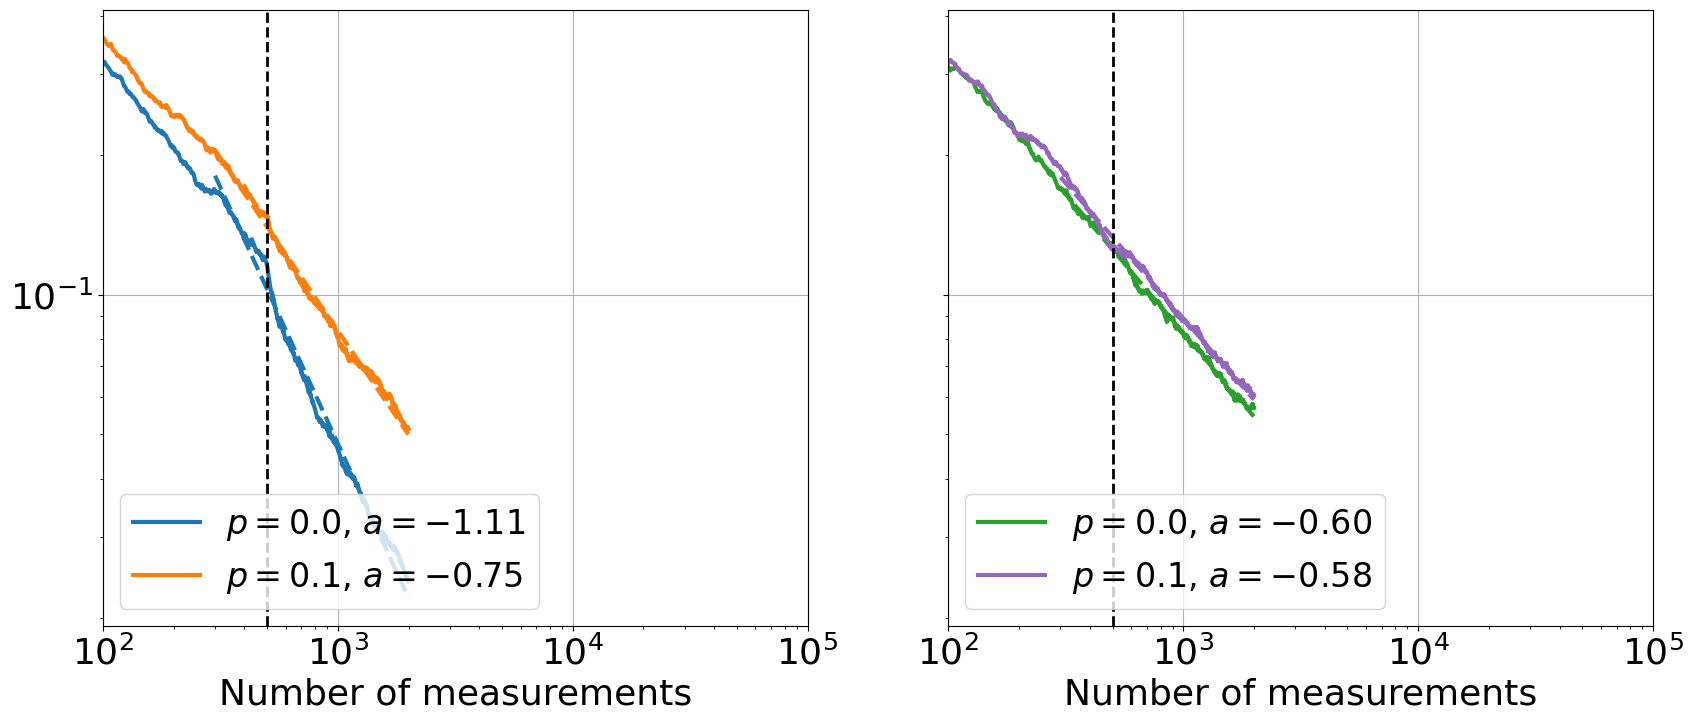

In [ ]:
settings = setting_array[0]
n_shots = settings['n_shots']
n_qubits = settings['n_qubits']
n_averages = settings['n_averages']
adaptive_burnin = settings['adaptive_burnin']
noise_strengths = settings['noise_strengths']
def power_law(x,a,b):
    return a*x**(b)
infidelity_container1 = adaptive_infidelity_container[0]
infidelity_container2 = nonadaptive_infidelity_container[0]

print(np.shape(infidelity_container1))
print(np.shape(infidelity_container2))

cutoff = 100
fitcutoff = 300
x = np.arange(len(infidelity_container1[0][0]))
x_2 = np.arange(len(infidelity_container2[0][0]))

mean_infidelities = [np.mean(container, axis=1) for container in [infidelity_container1, infidelity_container2]]
colors = ['C0', 'C1', 'C2', 'C4', 'red', 'C5', 'C6', 'C7', 'C8'] #  0 and 4 uses same colors as they are the same curve
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plt.rcParams.update({'font.size': 26})
print(np.shape(mean_infidelities))



# Assume mean_infidelities and labels are lists of lists/arrays, where each sublist corresponds to a subplot
# Example: mean_infidelities = [mean_infidelities_set1, mean_infidelities_set2]
#          labels = [labels_set1, labels_set2]
labels = [noise_strengths, noise_strengths]  # Example labels for each subplot
print(labels)
#labels = [[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]]
for idx, ax in enumerate(axes):
    for i in range(len(mean_infidelities[idx])):
       
        # if idx == 0 and i == 0:
        #     popt, pcov = curve_fit(power_law, x[fitcutoff:], mean_infidelities[1][i][fitcutoff:], p0=np.array([1, -0.5]))
        #     infiFit = power_law(x[fitcutoff:], popt[0], popt[1])
        #     ax.plot(x[fitcutoff:], infiFit, '--', color=colors[i +1*len(mean_infidelities[0])], linewidth=3)
        #     ax.plot(x[cutoff:], mean_infidelities[1][i][cutoff:], label=rf'$p={np.round(labels[0][i],3)}$, $a={"%.2f" % popt[1]}$' if labels else None, color=colors[i+1*len(mean_infidelities[0])], linewidth=3)
        #print(x[fitcutoff:])
        #print(mean_infidelities[idx][i][fitcutoff:])
        popt, pcov = curve_fit(power_law, x[fitcutoff:], mean_infidelities[idx][i][fitcutoff:], p0=np.array([1, -0.5]))
        infiFit = power_law(x[fitcutoff:], popt[0], popt[1])
        ax.plot(x[fitcutoff:], infiFit, '--', color=colors[i +idx*len(mean_infidelities[0])], linewidth=3)
        #print(labels[idx][i])
        ax.plot(x[cutoff:], mean_infidelities[idx][i][cutoff:], label=rf'$p={np.round(labels[idx][i],3)}$, $a={"%.2f" % popt[1]}$' if labels else None, color=colors[i+idx*len(mean_infidelities[0])], linewidth=3)
    
    ax.axvline(x=adaptive_burnin, color='black', linestyle='--', linewidth=2 )
    ax.set_xlabel('Number of measurements')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(cutoff, 100000)
    ax.grid()
    
    ax.legend(loc= "lower left",fontsize=24)

## Infidelity threshold

50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025


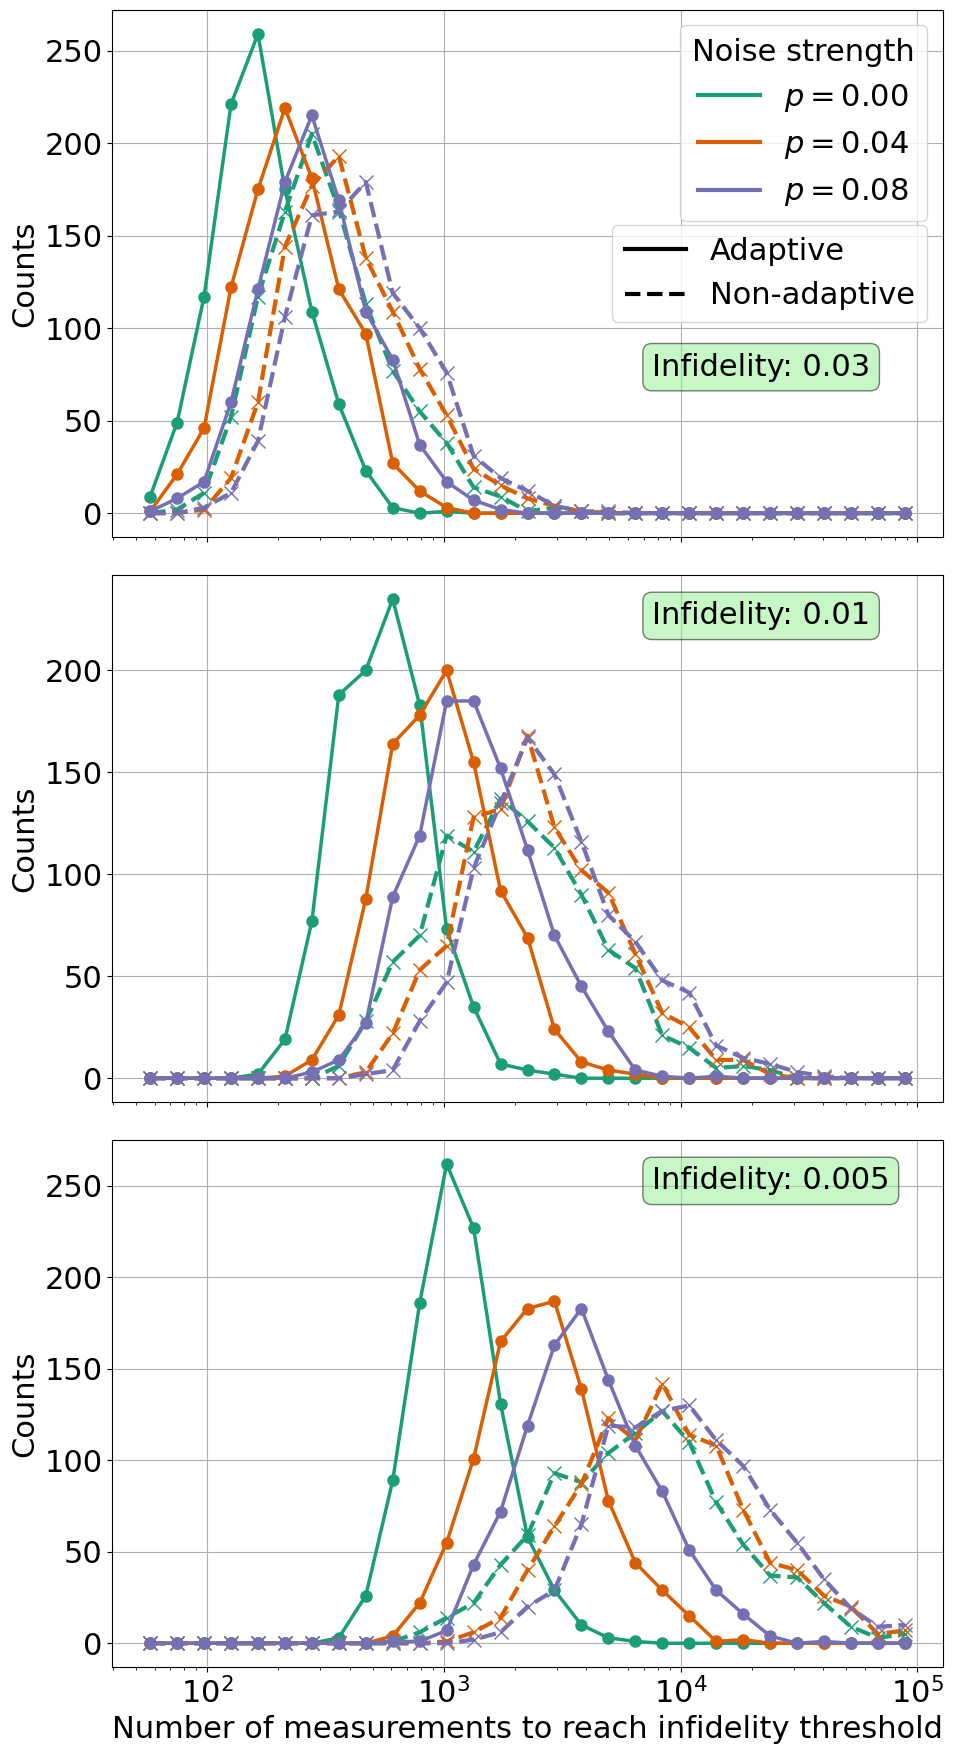

In [51]:
def find_infidelity_cross_array(threshold_value, inf_container):
    # Containers has [#separate_fils, #err_runs, #N_averages, #N_shots ]
    shape = np.shape(inf_container)
    reshaped_container = np.einsum('ijkl->jikl', inf_container)
    combined_container = np.reshape(reshaped_container, (shape[0], -1, shape[-1]))
    #print(np.shape(combined_container))
    full_cross_array = []
    for container in combined_container:
        cross_array = []
        for run in container:
            arg_crosses = np.argwhere(run < threshold_value)
            if len(arg_crosses) > 0:
                cross_array.append([arg_crosses[0][0]])
            else:   
                cross_array.append([len(run)]) # If it never crosses the threshold, we set it to infinity.
        full_cross_array.append(cross_array)
    return np.reshape(full_cross_array, (shape[1], -1))


# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued
threshold_values = [0.03, 0.01,0.005]


fig,axes = plt.subplots(len(threshold_values),1, figsize=(10,6*len(threshold_values)), sharex=True)
for i, ax in enumerate(axes):
    ada_cross_array = find_infidelity_cross_array(threshold_values[i], one_qubit_adaptive_inf_con)[:-1]
    noada_cross_array = find_infidelity_cross_array(threshold_values[i], one_qubit_nonadaptive_inf_con)[:-1]
    for noise_index in range(len(ada_cross_array)):
        #combined_array = np.concatenate((ada_cross_array, noada_cross_array), axis=0)
        min_value = 50#np.min(ada_cross_array)
        max_value = 10**5#np.max(noada_cross_array)
        print(min_value, max_value)
        steps = 30
        levels = np.logspace(np.log10(min_value), np.log10(max_value), steps)   


        # --- if your find_corss_array returns 1-element arrays, make sure rows are scalars ---
        def _row_to_1d_int(arr_row):
            """Safely flatten a possibly ragged row of 1-element arrays into ints."""
            # e.g. arr_row could look like [array([12]), array([7]), ...]
            flat = [int(np.ravel(x)[0]) for x in arr_row]
            return np.asarray(flat)

        # Take the first row from each cross array and coerce to 1D ints
        ada_vals = _row_to_1d_int(ada_cross_array[noise_index])
        noada_vals = _row_to_1d_int(noada_cross_array[noise_index])

        # Use your 'levels' as bin edges
        bin_edges = np.asarray(levels)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Histograms over the provided bins
        ada_counts, _   = np.histogram(ada_vals, bins=bin_edges)
        noada_counts, _ = np.histogram(noada_vals, bins=bin_edges)

        print(f'Adaptive counts: {np.sum(ada_counts)}, Non-adaptive counts: {np.sum(noada_counts)}')
        # Plot as curves over the discrete bins

        ax.plot(bin_centers, ada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_ada, marker='o', markersize=ada_markersize, linestyle='-', label=f'Adaptive {threshold_values[i]}')
        ax.plot(bin_centers, noada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_nonada, marker='x', markersize=nonada_markersize, linestyle='--', label=f'Non-adaptive {threshold_values[i]}')
        ax.set_xscale('log')
        ax.set_ylabel('Counts')
        ax.grid(True, alpha=1)





# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths[:-1])]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]

leg1 = axes[0].legend(handles=color_handles, title='Noise strength', loc='upper right', frameon=True)
axes[0].add_artist(leg1)  # add the first legend manually
axes[0].legend(handles=style_handles, loc='center right', frameon=True) # keep first legend when adding the second
#plt.legend(handles=style_handles, loc='upper right', frameon=True)

axes[2].set_xlabel('Number of measurements to reach infidelity threshold')


axes[0].text(0.65, 0.35, fr'Infidelity: {threshold_values[0]}', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].text(0.65, 0.95, fr'Infidelity: {threshold_values[1]}', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[2].text(0.65, 0.95, fr'Infidelity: {threshold_values[2]}', transform=axes[2].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
fig.savefig("Images/Shots_to_reach_infidelity.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()



## Shot threshold

Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025


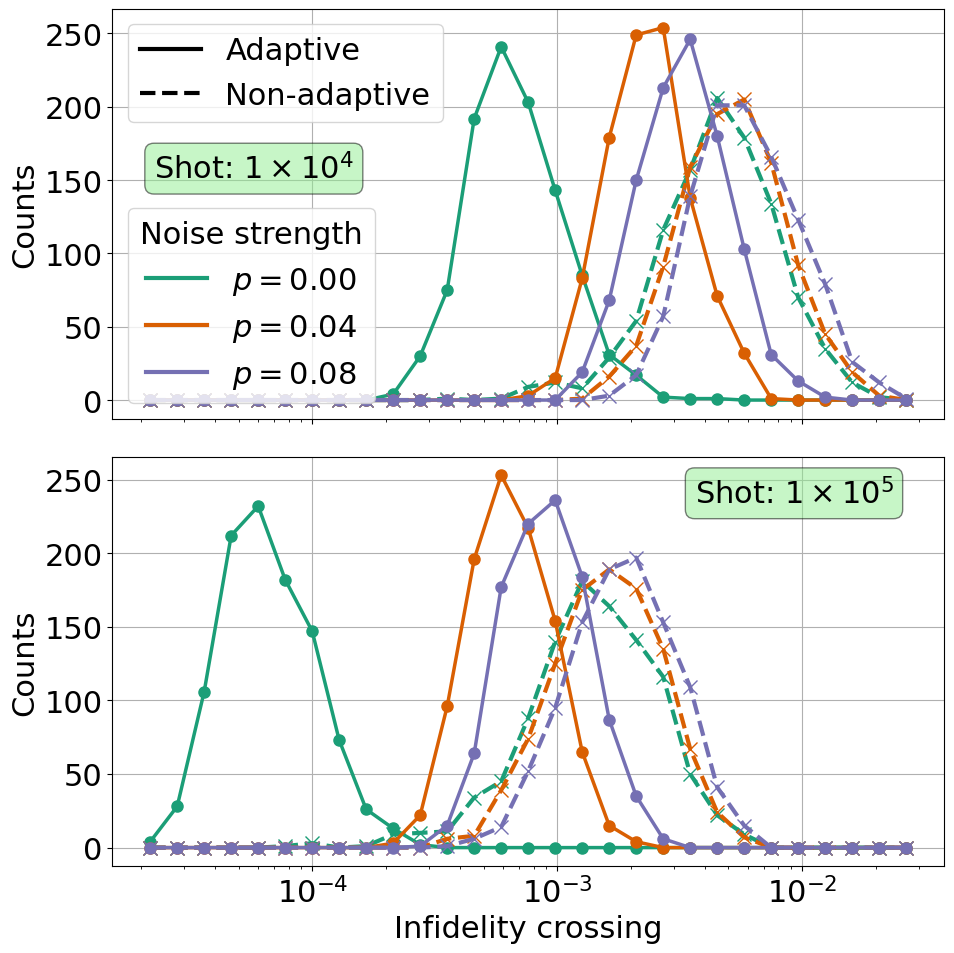

In [52]:
def find_shot_cross_array(shot_value, inf_container):
    # Containers has [#separate_fils, #err_runs, #N_averages, #N_shots ]
    shape = np.shape(inf_container)
    reshaped_container = np.einsum('ijkl->jikl', inf_container)
    combined_container = np.reshape(reshaped_container, (shape[0], -1, shape[-1]))
    #print(np.shape(combined_container))
    full_cross_array = []
    for container in combined_container:
        cross_array = []
        for run in container:
            cross_array.append(run[shot_value])
        full_cross_array.append(cross_array)
    return np.reshape(full_cross_array, (shape[1], -1))


# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
lw_fit      = 3.0
ada_markersize = 8
nonada_markersize = 10
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued


shot_values = [10000,99998]
fig,axes=plt.subplots(2,1,figsize=(10,10),sharex=True)

#print(ada_cross_array)

for i,ax in enumerate(axes):
    shot_value = shot_values[i]
    ada_cross_array = find_shot_cross_array(shot_values[i], one_qubit_adaptive_inf_con)[:-1]
    noada_cross_array = find_shot_cross_array(shot_values[i], one_qubit_nonadaptive_inf_con)[:-1]
    for noise_index in range(len(ada_cross_array)):
        #combined_array = np.concatenate((ada_cross_array, noada_cross_array), axis=0)
        min_value = 1.9e-05 #np.min(ada_cross_array)
        max_value = 0.03#np.max(noada_cross_array)
        #print(min_value, max_value)
        steps = 30
        levels = np.logspace(np.log10(min_value), np.log10(max_value), steps)

        #print(levels)
        # --- if your find_corss_array returns 1-element arrays, make sure rows are scalars ---
        def _row_to_1d_int(arr_row):
            """Safely flatten a possibly ragged row of 1-element arrays into ints."""
            # e.g. arr_row could look like [array([12]), array([7]), ...]
            flat = [np.ravel(x)[0] for x in arr_row]
            return np.asarray(flat)

        # Take the first row from each cross array and coerce to 1D ints
        ada_vals = _row_to_1d_int(ada_cross_array[noise_index])
        noada_vals = _row_to_1d_int(noada_cross_array[noise_index])

        # Use your 'levels' as bin edges
        bin_edges = np.asarray(levels)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #print(bin_centers)
        # Histograms over the provided bins
        ada_counts, _   = np.histogram(ada_vals, bins=bin_edges)
        noada_counts, _ = np.histogram(noada_vals, bins=bin_edges)
        #print(ada_counts)
        print(f'Adaptive counts: {np.sum(ada_counts)}, Non-adaptive counts: {np.sum(noada_counts)}')
        # Plot as curves over the discrete bins

        ax.plot(bin_centers, ada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_ada, marker='o', markersize=ada_markersize, linestyle='-', label=f'Adaptive {shot_value}')
        ax.plot(bin_centers, noada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_nonada, marker='x', markersize=nonada_markersize, linestyle='--', label=f'Non-adaptive {shot_value}')
        ax.set_xscale('log')
        ax.set_ylabel('Counts')
        ax.grid(True, alpha=0.3)




# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths[:-1])]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]

leg1 = axes[0].legend(handles=color_handles, title='Noise strength',loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
 # keep first legend when adding the second
axes[0].grid(True, alpha=1)
axes[1].grid(True, alpha=1)
axes[0].legend(handles=style_handles, loc='upper left', frameon=True)

axes[1].set_xlabel('Infidelity crossing')
# def sci_notation_latex(n, precision=0):
#     # Convert to scientific notation string
#     s = f"{n:.{precision}e}"
#     base, exp = s.split("e")
#     exp = int(exp)
#     return f"{base} \\times 10^{{{exp}}}"
axes[0].text(0.05, 0.65, fr'Shot: $1 \times 10^4$', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].text(0.7, 0.95, fr'Shot: $1 \times 10^5$', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
fig.savefig("Images/Infidelity_at_shot_threshold.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Full infidelity plot

Found 3 folders
Folder 0: adaptive_results/two_qubit_longtest/2025-10-15_09-37-58_1d0d5027-71bc-4617-86ad-871d53cd70fb
Folder 1: adaptive_results/two_qubit_longtest/2025-10-15_09-38-00_4dd259b8-3ab5-442d-abc7-236a48cd0af0
Folder 2: adaptive_results/two_qubit_longtest/2025-10-15_09-38-24_0379a09e-0609-44e7-864e-1a32c2873269
(5, 9999)


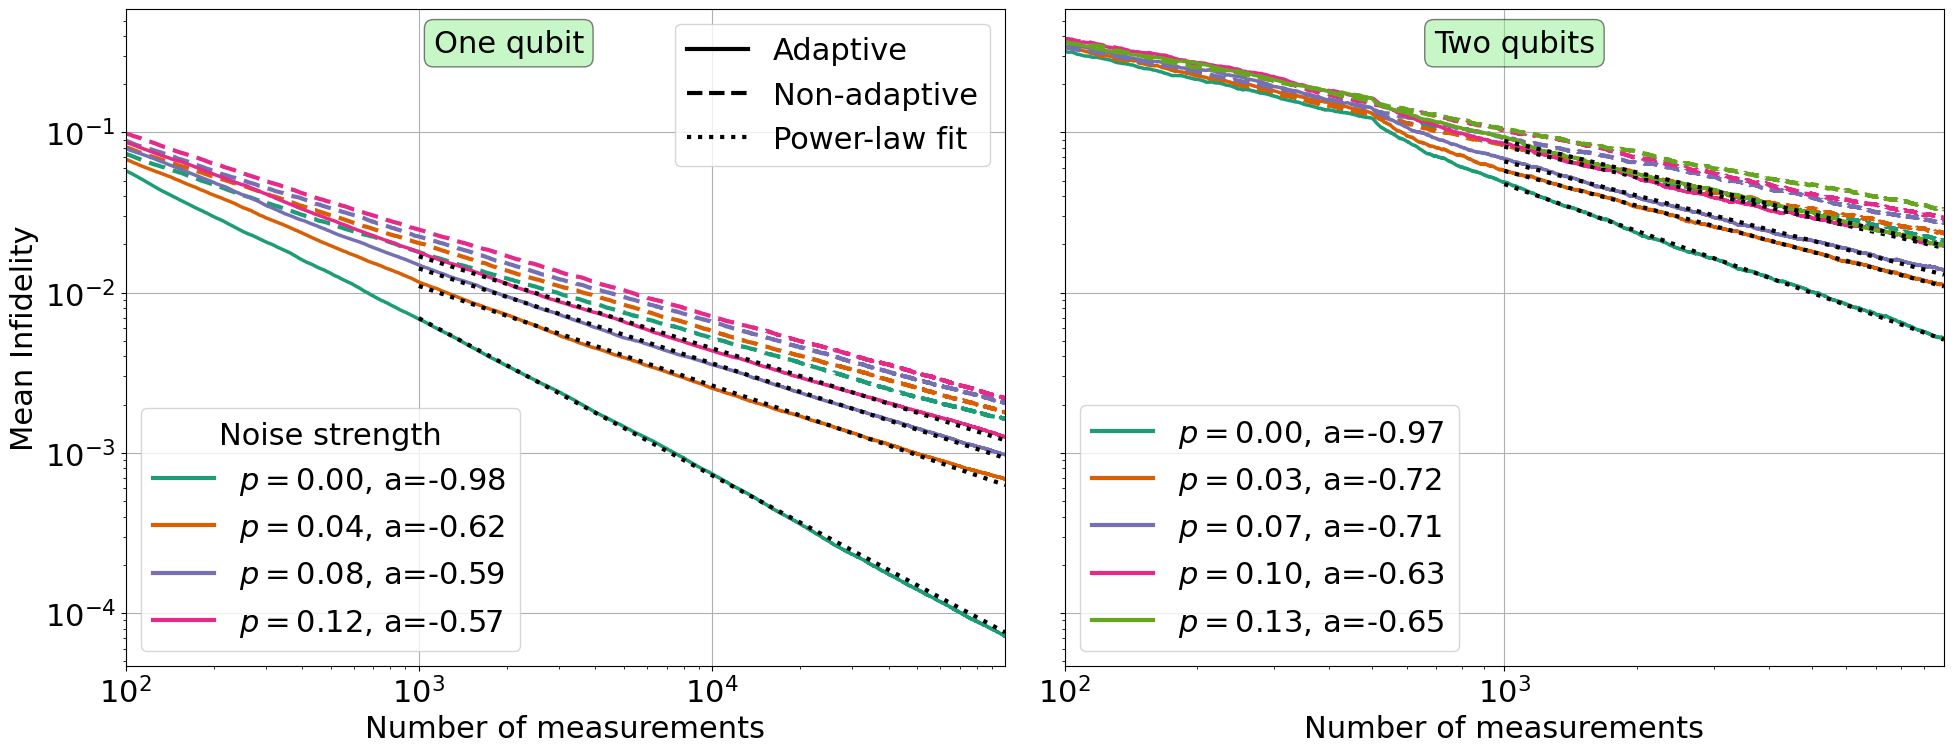

In [ ]:
one_qubit_settings = one_qubit_setting_array[0]
adaptive_burnin = one_qubit_settings['adaptive_burnin']
one_qubit_noise_strengths = one_qubit_settings['noise_strengths']

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Expect shape: (n_strengths, n_averages, n_points)
mean_one_qubit_ada   = np.mean(one_qubit_adaptive_inf_con, axis=(0,2))   # (n_points,)
mean_one_qubit_nonade  = np.mean(one_qubit_nonadaptive_inf_con, axis=(0,2))   # (n_points,)

# X-axes (allow different lengths just in case)
x_one_qubit   = np.arange(np.shape(one_qubit_adaptive_inf_con)[-1])

adaptive_exponent_fit = []
cutoff     = 100
fitcutoff  = 1000  # fit only after twice the burn-in

# --- color map keyed by noise strength ---

color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}

# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"Adaptive p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_nonade[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # fits (on their own native x after fitcutoff)
    popt_ad,  _ = curve_fit(power_law, x_one_qubit[fitcutoff:],  mean_one_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    popt_non, _ = curve_fit(power_law, x_one_qubit[fitcutoff:], mean_one_qubit_nonade[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    adaptive_exponent_fit.append(popt_ad[1])

    axes[0].plot(x_one_qubit[fitcutoff:],  power_law(x_one_qubit[fitcutoff:],  *popt_ad),
            fit_style, color='k', linewidth=lw_fit)
    #ax.plot(x_non[fitcutoff:], power_law(x_non[fitcutoff:], *popt_non),
    #        fit_style, color='k', linewidth=lw_fit)

# burn-in marker
#axes[0].axvline(x=adaptive_burnin, color='black', linestyle='--', linewidth=2)
#axes[0].axhline(y=0.01, color='gray', linestyle=':', linewidth=2)
# axes formatting
axes[0].text(0.35, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[0].set_xlabel('Number of measurements')
axes[0].set_ylabel('Mean Infidelity')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(cutoff, x_one_qubit[-1])
axes[0].grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$, a={scale:.2f} ')
                 for p, scale in zip(one_qubit_noise_strengths, adaptive_exponent_fit)]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=fit_style,                   label='Power-law fit')
]

leg1 = axes[0].legend(handles=one_qubit_color_handles, title='Noise strength', loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
axes[0].legend(handles=style_handles, loc='upper right', frameon=True)



# Two qubit plot
two_qubit_path = 'adaptive_results/two_qubit_longtest'
glob_path = os.path.join(two_qubit_path, '*.npy')

two_qubit_adaptive_container = []
two_qubit_nonadaptive_container = []
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(two_qubit_path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        two_qubit_setting_array = np.load(f, allow_pickle=True)
    two_qubit_adaptive_container.append(infidelity_dict['adaptive_infidelity_container'])
    two_qubit_nonadaptive_container.append(infidelity_dict['nonadaptive_infidelity_container'])
two_qubit_noise_strengths = two_qubit_setting_array[0]['noise_strengths']


# --- color map keyed by noise strength ---
color_map_two_qubit   = {p: cmap(i) for i, p in enumerate(two_qubit_noise_strengths)}
# Compute means
mean_two_qubit_ada = np.mean(two_qubit_adaptive_container, axis=(0, 2))
mean_two_qubit_nonada = np.mean(two_qubit_nonadaptive_container, axis=(0, 2))
print(np.shape(mean_two_qubit_ada))
x_two_qubit = np.arange(np.shape(two_qubit_adaptive_container)[-1])
two_qubit_adaptive_exponent_fit = []
# Plotting
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_nonada[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # fits (on their own native x after fitcutoff)
    popt_ad,  _ = curve_fit(power_law, x_two_qubit[fitcutoff:],  mean_two_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    popt_non, _ = curve_fit(power_law, x_two_qubit[fitcutoff:], mean_two_qubit_nonada[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    two_qubit_adaptive_exponent_fit.append(popt_ad[1])

    axes[1].plot(x_two_qubit[fitcutoff:],  power_law(x_two_qubit[fitcutoff:],  *popt_ad),
            fit_style, color='k', linewidth=lw_fit)

# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
two_qubit_color_handles = [Line2D([0], [0], color=color_map_two_qubit[p], lw=3, label=rf'$p={p:.2f}$, a={scale:.2f} ')
                 for p, scale in zip(two_qubit_noise_strengths, two_qubit_adaptive_exponent_fit)]


axes[1].legend(handles=two_qubit_color_handles, loc='lower left', frameon=True)
axes[1].text(0.42, 0.97, 'Two qubits', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)

axes[1].set_xlabel('Number of measurements')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(cutoff, x_two_qubit[-1])
axes[1].grid(True, alpha=1)

#axes[1].legend()
fig.savefig("Images/Infidelity_comparison.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()
